In [1]:
import os
import tensorflow as tf
import io
import numpy as np
import tensorflow_addons as tfa

D:\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
#Define variables

batch_size = 32
img_height = 250
img_width = 250
img_channels = 3

data_dir = 'data_folder/lfw_processed'

In [3]:
#Load LFW Data

dev_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 9164 files belonging to 1680 classes.


In [4]:
#Normalize pixel function

@tf.autograph.experimental.do_not_convert
def _normalize_img(img, label):
    image = tf.cast(img/255. ,tf.float32)
    return image, label

In [5]:
dev_dataset = dev_ds.map(_normalize_img)

In [6]:
#Load Pubfig Data

data_dir = 'data_folder/pubfig'

pubfig_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  shuffle=True,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

pubfig_dataset = pubfig_ds.map(_normalize_img)

Found 11640 files belonging to 150 classes.


In [7]:
#Split Pubfig data 0.6/0.2/0.2

train_split = 0.6
val_split = 0.2
test_split = 0.2

ds_size = len(list(pubfig_dataset))
train_size = int(train_split * ds_size)
val_size = int(val_split * ds_size)
test_size = int(test_split * ds_size)

train_ds = pubfig_dataset.take(train_size)    
val_ds = pubfig_dataset.skip(train_size).take(val_size)
test_ds = pubfig_dataset.skip(train_size + val_size).take(test_size)

In [12]:
#Load Pretrained and Tuned Model

pretrained_model = tf.keras.models.load_model('saved_model/pretrained_model')
tuned_model = tf.keras.models.load_model('saved_model/tuned_model')

In [39]:
#Constuct a database of known image encodings from the training/verification dataset as a reference to evaluate the test dataset

pubfig_db_dict = {}
for images, labels in train_ds.take(250):
    for i in range(labels.shape[0]):
        if int(labels[i]) not in pubfig_db_dict:
            pubfig_db_dict[int(labels[i])] = tuned_model.predict(np.expand_dims(images[i], axis=0))
            
for images, labels in val_ds.take(100):
    for i in range(labels.shape[0]):
        if int(labels[i]) not in pubfig_db_dict:
            pubfig_db_dict[int(labels[i])] = tuned_model.predict(np.expand_dims(images[i], axis=0))

1/1 [==============================] - 0s 90ms/step


In [47]:
#For Each Image in the test set, compute the closest image embedding
#If it is closer than the threshold, classify the image as that class
#If it is further than the threshold, the test image is not in the referance classes

test_num = 0
test_correct = 0
total_distance = 0

threshold = 1.3

for images, labels in test_ds.take(100):
    for i in range(labels.shape[0]):
        #Establish Target and test encoding
        test_label = int(labels[i])
        test_encoding = tuned_model.predict(np.expand_dims(images[i], axis=0))
        
        # Initialize "min_dist" to a large value, say 100 (≈1 line)
        min_dist = 100
        min_label = 0
        
        #Loop through all images in dataset and find closests
        for key in pubfig_db_dict.keys():
            db_enc = pubfig_db_dict[key]
            
            #compute L2 distance
            dist = np.linalg.norm(db_enc - test_encoding)
            
            #set new label if smallest distance seen
            if dist < min_dist:
                min_dist = dist
                min_label = key
                
            if key == test_label:
                total_distance += dist
        
        test_num += 1
        if min_dist < threshold:
            if min_label == test_label:
                test_correct += 1
        elif test_label not in pubfig_db_dict:
            test_correct += 1
        

1/1 [==============================] - 0s 111ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 114ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 82ms/step


In [49]:
#Print Facial Recognition Accuracy and Average Distance from correct class

print(test_correct/test_num)
print(total_distance/test_num)

0.1189236111111111
1.2084001855045143


In [53]:
#Load training Loss Data

import pandas as pd

pretrained_df = pd.read_csv('saved_model/pre_train_history.csv')
tuned_df = pd.read_csv('saved_model/tune_history.csv')

<AxesSubplot:title={'center':'Model Pretraining on LWF Dataset'}, xlabel='Epochs', ylabel='Triplet Loss'>

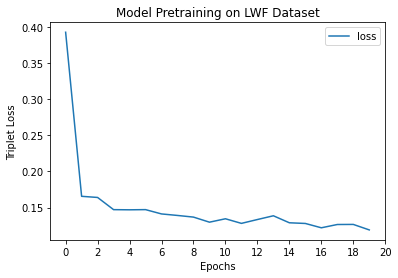

In [72]:
#Plot Pretrained data

pretrained_df.plot(x=0, y=1, kind='line', title='Model Pretraining on LWF Dataset', xlabel='Epochs', ylabel='Triplet Loss', xticks=[0,2,4,6,8,10,12,14,16,18,20])

<AxesSubplot:title={'center':'Model Tuning on Pubfig Dataset'}, xlabel='Epochs', ylabel='Triplet Loss'>

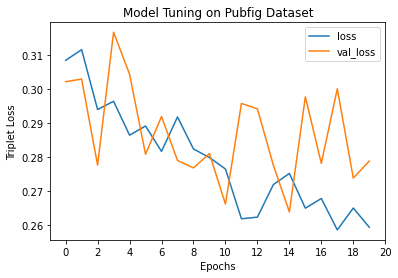

In [73]:
#Plot tuned data

tuned_df.plot(x=0, y=[1,2], kind='line', title='Model Tuning on Pubfig Dataset', xlabel='Epochs', ylabel='Triplet Loss', xticks=[0,2,4,6,8,10,12,14,16,18,20])